In [1]:
import io, json
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

In [2]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 9.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1623306 sha256=cf19b7052d24009a2c17719499cb278a156db684c134bfc19f48c564fe0242e4
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
# Import the following modules from the Surprise 
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import BaselineOnly
from surprise import CoClustering
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import Reader

In [4]:
df=pd.read_csv("/Dataset/Data Mining Data/datamining_data.csv")
df["id"]=df.id.astype(int)

In [5]:
df.head()

,Unnamed: 0,condition,end,id_x,start,successful,therapy,cured,diagnosed,isCured,isTreated,kind,id
0,0,pc3,20120109,tr1,20111219,86.0,Th49,20120404,20111218,True,True,Cond240,0
1,1,pc3,20120217,tr2,20120203,10.0,Th45,20120404,20111218,True,True,Cond240,0
2,2,pc3,20120404,tr3,20120330,100.0,Th45,20120404,20111218,True,True,Cond240,0
3,3,pc4,19650727,tr4,19650714,100.0,Th17,19650727,19650601,True,True,Cond39,0
4,4,pc5,19731019,tr5,19730919,100.0,Th47,19731019,19730915,True,True,Cond309,0


In [6]:
data_p=df[["id","kind","therapy","successful"]]

In [7]:
data_p["id"] = data_p["id"].astype(str) + "-" + data_p["kind"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
data_p=data_p[["id","therapy","successful"]]

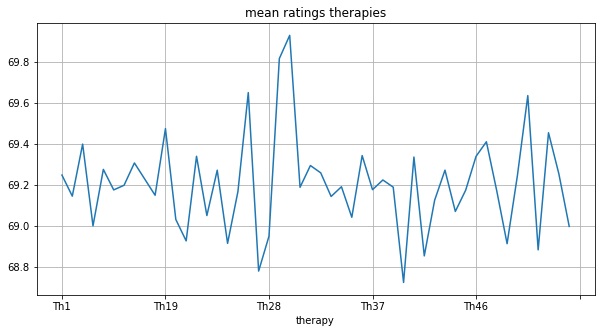

In [45]:
movie_means = data_p.groupby('therapy').successful.mean()
movie_means[:50].plot(kind='line', grid=True, figsize=(10,5), title="mean ratings therapies")

## Experiment 1 Full Dataset

In [ ]:
# Rating scale to be used as part of the process of using Surprise to predict ratings ("Scores" in this case)
reader = Reader(rating_scale=(0, 100))

# Convert the pandas dataframe into a Surprise dataset using the load_from_df() method
# The 'UserId', 'ProductId', and ratings ('Score' in this case) are passed in the exact order
data = Dataset.load_from_df(data_p[['id', 'therapy', 'successful']], reader)
# split the data into train and test set
# Use 75% of the dataset for training and 25% for testing
trainset, testset = train_test_split(data_p, test_size=0.04)

In [13]:
from surprise.model_selection import train_test_split
from surprise import accuracy

# 'user_based' in the similarity option (sim_options) is set to True in order to compute a User based collaborative filtering.
sim_options= {'name':'cosine', 
              'user_based':True
             } 
for algorithm in [SVD(), SVDpp()]:

  # Fit algorithm to the training set
  algorithm.fit(trainset)
  # Predict ratings for the test set
  test_set_predictions=algorithm.test(testset)
  # Calculate the root mean squared error(RMSE)
  print(algorithm)
  accuracy.rmse(test_set_predictions)

RMSE: 33.5020
RMSE: 45.6652


In [49]:
data_p

,id,therapy,successful
0,0-Cond240,Th49,86.0
1,0-Cond240,Th45,10.0
2,0-Cond240,Th45,100.0
3,0-Cond39,Th17,100.0
4,0-Cond309,Th47,100.0
...,...,...,...
1027025,99999-Cond128,Th50,100.0
1027026,99999-Cond280,Th28,20.0
1027027,99999-Cond135,Th19,53.0
1027028,99999-Cond135,Th8,100.0


## Experiment 2 patients  selected who had at least one trial for same condition and whose most recent trial had ended with a higher utility

In [77]:
data_exp=data_p["id"]+","+data_p["therapy"]
data_exp=pd.DataFrame(data_exp)
data_exp["successful"]=data_p["successful"]
data_exp.columns=["id","successful"]
data_exp_1=pd.DataFrame(data_exp.groupby("id").successful.max()).reset_index()
dt=data_exp_1["id"].str.split(",", n = 1, expand = True)
dt["successful"]=data_exp_1["successful"]
dt.columns=["id","therapy","successful"]

In [79]:
dt

,id,successful
0,"0-Cond240,Th49",86.0
1,"0-Cond240,Th45",10.0
2,"0-Cond240,Th45",100.0
3,"0-Cond39,Th17",100.0
4,"0-Cond309,Th47",100.0
...,...,...
1027025,"99999-Cond128,Th50",100.0
1027026,"99999-Cond280,Th28",20.0
1027027,"99999-Cond135,Th19",53.0
1027028,"99999-Cond135,Th8",100.0


In [90]:
# Rating scale to be used as part of the process of using Surprise to predict ratings ("Scores" in this case)
reader = Reader(rating_scale=(0, 100))

# Convert the pandas dataframe into a Surprise dataset using the load_from_df() method
# The 'UserId', 'ProductId', and ratings ('Score' in this case) are passed in the exact order
data = Dataset.load_from_df(dt[['id', 'therapy', 'successful']], reader)
# split the data into train and test set
# Use 75% of the dataset for training and 25% for testing
trainset, testset = train_test_split(data, test_size=0.20)

In [91]:
from surprise.model_selection import train_test_split
from surprise import accuracy

for algorithm in [SVD(), SVDpp()]:

  # Fit algorithm to the training set
  algorithm.fit(trainset)
  # Predict ratings for the test set
  test_set_predictions=algorithm.test(testset)
  # Calculate the root mean squared error(RMSE)
  print(algorithm)
  accuracy.rmse(test_set_predictions)

RMSE: 34.4808
RMSE: 46.6641
